In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

## Import CPI data

The data comes from destatis: https://www-genesis.destatis.de/genesis/online?sequenz=statistikTabellen&selectionname=61111


In [5]:
cols = ["year","month","CPI", "annual_change", "monthly_change"]
m_inf = pd.read_csv(
    'data/61111-0002.csv', encoding="ISO-8859-3", 
    skiprows=6, sep=';', header=None,names=cols, decimal=',',
    skipfooter=3
)
# Create a date columns
m_inf['m'] = m_inf.index % 12 + 1
m_inf['date'] = pd.to_datetime(m_inf.year.astype(str) + '/' + m_inf.m.astype(str) + '/01')

# Define starting point
m_inf = m_inf[m_inf['date']>=pd.to_datetime(date(2003,1,1))].reset_index(drop=True)

# Replace ... with None and parse CPI as float
m_inf = m_inf.replace('...',None)
m_inf['CPI'] = m_inf['CPI'].astype(float)

# Parse monthly change
m_inf['monthly_change'] = m_inf['monthly_change'].replace('-',0).astype(float)

# Rebase inflation from starting point
now = pd.to_datetime(date(2023,9,1))
base = m_inf.loc[m_inf['date']==now,'CPI'].values[0]

m_inf['CPI_base'] = m_inf['CPI'] / base

m_inf



/tmp/ipykernel_383756/184322237.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  m_inf = pd.read_csv(


,year,month,CPI,annual_change,monthly_change,m,date,CPI_base
0,2003,Januar,78.5,+1.0,0.0,1,2003-01-01,0.666384
1,2003,Februar,79.0,+1.3,0.6,2,2003-02-01,0.670628
2,2003,März,79.0,+1.0,0.0,3,2003-03-01,0.670628
3,2003,April,78.8,+0.9,-0.3,4,2003-04-01,0.668930
4,2003,Mai,78.6,+0.5,-0.3,5,2003-05-01,0.667233
...,...,...,...,...,...,...,...,...
247,2023,August,117.5,+6.1,0.3,8,2023-08-01,0.997453
248,2023,September,117.8,+4.5,0.3,9,2023-09-01,1.000000
249,2023,Oktober,NaN,None,NaN,10,2023-10-01,NaN
250,2023,November,NaN,None,NaN,11,2023-11-01,NaN


# Create table of TV Stud pay

In [7]:
from datetime import date
tvst = [
    {"date": date(2003,1,1), 'tv_stud': 10.98},
    {"date": date(2018,6,1), 'tv_stud': 12.30},
    {"date": date(2019,1,1), 'tv_stud': 12.50},
    {"date": date(2021,1,1), 'tv_stud': 12.68},
    {"date": date(2022,1,1), 'tv_stud': 12.96},
    {"date": date(2024,1,1), 'tv_stud': 12.96*1.1},
]
tvsdf = pd.DataFrame.from_dict(tvst)
tvsdf['date'] = pd.to_datetime(tvsdf['date'])
tvsdf

,date,tv_stud
0,2003-01-01,10.980
1,2018-06-01,12.300
2,2019-01-01,12.500
3,2021-01-01,12.680
4,2022-01-01,12.960
5,2024-01-01,14.256


# Create table of minimum wage

In [8]:
mdl = [
    {"date": date(2015,1,1), 'mdl': 8.50}, #https://www.destatis.de/DE/Themen/Arbeit/Verdienste/Mindestloehne/Tabellen/gesetzlicher-mindestlohn.html
    {"date": date(2017,3,1), 'mdl': 8.84}, 
    {"date": date(2019,1,1), 'mdl': 9.19},
    {"date": date(2020,9,1), 'mdl': 9.35},
    {"date": date(2021,1,1), 'mdl': 9.50},
    {"date": date(2021,7,1), 'mdl': 9.60},
    {"date": date(2022,1,1), 'mdl': 9.82},
    {"date": date(2022,7,1), 'mdl': 10.45},
    {"date": date(2022,10,1), 'mdl': 12},
]
mdldf = pd.DataFrame.from_dict(mdl)
mdldf['date'] = pd.to_datetime(mdldf['date'])
mdldf

,date,mdl
0,2015-01-01,8.50
1,2017-03-01,8.84
2,2019-01-01,9.19
3,2020-09-01,9.35
4,2021-01-01,9.50
5,2021-07-01,9.60
6,2022-01-01,9.82
7,2022-07-01,10.45
8,2022-10-01,12.00


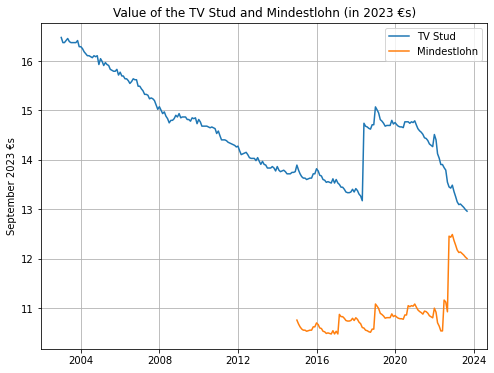

In [11]:
comp = m_inf.merge(tvsdf, how='outer').merge(mdldf,how='outer')
comp['tv_stud'] = comp['tv_stud'].fillna(method='ffill')
comp['tv_stud_real'] = comp['tv_stud'] / comp['CPI_base'] 
comp['mdl'] = comp['mdl'].fillna(method='ffill')
comp['mdl_real'] = comp['mdl'] / comp['CPI_base'] 
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(
    comp['date'],
    comp['tv_stud_real'],
    label='TV Stud'
)
ax.plot(
    comp['date'],
    comp['mdl_real'],
    label='Mindestlohn'
)
ax.legend()
ax.set_ylabel('September 2023 €s')
ax.set_title('Value of the TV Stud and Mindestlohn (in 2023 €s)')
ax.grid()

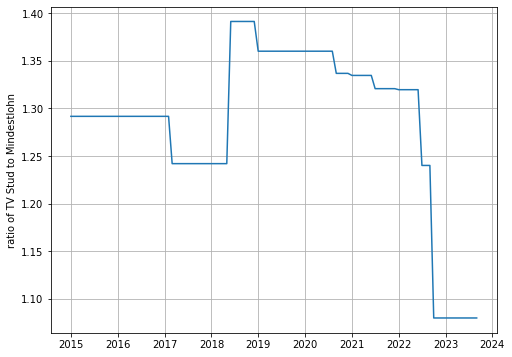

In [59]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(
    comp['date'],
    comp['tv_stud_h'] / comp['mdl_h']
)
ax.set_ylabel('ratio of TV Stud to Mindestlohn')
ax.grid()